In [78]:
import numpy as np
import scipy
from scipy.linalg import expm
import random
import math
from scipy.stats import unitary_group
import matplotlib.pyplot as plt
from scipy.optimize import minimize, curve_fit, basinhopping
import matplotlib
import torch.nn as nn
import torch.optim as optim

import torch

In [79]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [80]:
data = []
for ch in range(4):
    for H in range(3):
        with open(f"Calibration Example_915\ch{ch + 1}_H{H + 1}.txt") as file:
            for line in file:
                try:
                    row = [float(num) for num in line.split()]
                    data.append([H, ch] + row)
                except:
                    pass

def create_un_mat(v, device):
    Mc = torch.zeros((4, 4), dtype=torch.complex128, device=device)
    Mc[0, 1] = v[0] + 1j * v[1]
    Mc[1, 0] = v[0] - 1j * v[1]
    
    Mc[0, 2] = v[2] + 1j * v[3]
    Mc[2, 0] = v[2] - 1j * v[3]
    
    Mc[0, 3] = v[4] + 1j * v[5]
    Mc[3, 0] = v[4] - 1j * v[5]

    Mc[1, 2] = v[6] + 1j * v[7]
    Mc[2, 1] = v[6] - 1j * v[7]

    Mc[1, 3] = v[8] + 1j * v[9]
    Mc[3, 1] = v[8] - 1j * v[9]

    Mc[2, 3] = v[10] + 1j * v[11]
    Mc[3, 2] = v[10] - 1j * v[11]
    
    U = torch.matrix_exp(1j * Mc)

    return U

def f(v, data):

    M1 = create_un_mat(v[:12], device=device)
    M2 = create_un_mat(v[12:24], device=device)
    alpha = v[24:33].reshape(3, 3)
    h_0 = v[33:36]
    cost = torch.tensor(0.0, dtype=torch.double, device=device)
    for i in data:

        x = torch.zeros(3, dtype=torch.double, device=device)
        x[i[0]] = 10**(-5) * i[2] ** 2
        y = torch.tensor(i[3:], dtype=torch.complex128, device=device)
        y /= torch.sum(y)

        h_list = h_0 + alpha @ x
        H_diag = torch.cat([torch.exp(1j * h_list), torch.tensor([1.0], dtype=torch.complex128, device=device)])
        H = torch.diag(H_diag)

        predict = torch.abs((M2 @ H @ M1).T) ** 2
        cost += torch.norm(predict[i[1]] - y)
    return cost


In [81]:
test_params = [ 1.91326242,  0.33811433, -1.14337995,  0.52333614, -0.38834714,  0.14744523,
 -0.85982948,  0.52825861, -1.85198004,  1.99372634,  1.14918155,  1.73866765,
 -0.94870659, -1.72996879,  0.49429135,  0.84307355,  1.23083485,  0.02569966,
  0.82089312, -0.99859878, -1.65020273, -0.3302756 ,  1.2956594 , -0.11375081,
  0.89047027,  0.5254506 , -0.85310995, -1.29379862,  1.18014743, -0.67299028,
  1.08573217,  0.37724368, -0.60296156,  0.16611889,  0.08975488, -0.14965396]

# print(len(ok_params))

x0 = nn.Parameter(torch.tensor(test_params, dtype=torch.double, device=device), requires_grad=True)
optimizer = optim.LBFGS([x0], lr=0.01)

print(x0)

Parameter containing:
tensor([ 1.9133,  0.3381, -1.1434,  0.5233, -0.3883,  0.1474, -0.8598,  0.5283,
        -1.8520,  1.9937,  1.1492,  1.7387, -0.9487, -1.7300,  0.4943,  0.8431,
         1.2308,  0.0257,  0.8209, -0.9986, -1.6502, -0.3303,  1.2957, -0.1138,
         0.8905,  0.5255, -0.8531, -1.2938,  1.1801, -0.6730,  1.0857,  0.3772,
        -0.6030,  0.1661,  0.0898, -0.1497], device='cuda:0',
       dtype=torch.float64, requires_grad=True)


In [82]:
steps = 10

def closure():
    optimizer.zero_grad()
    loss = f(x0, data)
    loss.backward()
    print(f"loss: {loss.item()}")
    if loss.item() < 1e-5:
        print("Converged")
    return loss

for n in range(steps):
     print(f"Step {n + 1}/{steps}")
     optimizer.step(closure)
     print(x0.grad)
     if n == steps - 1:
         print("Final loss:", closure().item())
         print("Final parameters:", x0.data.cpu().numpy())

Step 1/10
loss: 372.8505191078404
loss: 372.85074518908493
loss: 372.850740681516
loss: 372.85073625348105
loss: 372.8507319110254
loss: 372.85072765325515
loss: 372.8507234788789
loss: 372.85071938646325
loss: 372.8507153745353
loss: 372.85071144160736
loss: 372.85070758619855
loss: 372.8507038068409
loss: 372.85070010208284
loss: 372.85069647048925
loss: 372.8506929106506
loss: 372.85068942117505
loss: 372.85068600069496
loss: 372.85068264786486
loss: 372.85067936136153
loss: 372.85067613988855
tensor([ 0.0204, -0.0733, -0.1509,  0.1235, -0.1418,  0.0044, -0.0175, -0.0994,
        -0.0589,  0.2165, -0.1119,  0.0745,  0.1149,  0.0655, -0.0510,  0.1599,
        -0.0553, -0.0569,  0.2276,  0.0135,  0.0041,  0.0372, -0.0593,  0.0922,
        -0.0213, -0.6362, -0.3431, -0.0210, -0.1624, -0.0803,  0.0178,  1.1192,
         0.7007, -0.1901, -0.0417,  0.2477], device='cuda:0',
       dtype=torch.float64)
Step 2/10
loss: 372.85067298217064
loss: 372.85066988695286
loss: 372.85066685301064
los

In [77]:
def numpy_loss(x_np, device):
    x_tensor = torch.tensor(x_np, dtype=torch.double, device=device)
    with torch.no_grad():
        loss = f(x_tensor, data)
    return float(loss.item())

from scipy.optimize import differential_evolution

bounds = [(-2, 2)] * len(x0)  # Define parameter bounds

result = differential_evolution(
    numpy_loss,
    bounds,
    strategy='best1bin',
    updating='immediate',  # Safe for compatibility
    workers=1              # Disable parallelism
)

print("🌍 Global DE best:", result.x)
print("Loss at DE best:", result.fun)

x0 = torch.tensor(result.x, dtype=torch.double, requires_grad=True, device=device)
optimizer = torch.optim.LBFGS([x0], lr=0.1, max_iter=100)

def closure():
    optimizer.zero_grad()
    loss = f(x0, data)
    loss.backward()
    print(f"loss: {loss.item()}")
    return loss

print("\n⚙️ Starting local refinement with LBFGS")
for n in range(100):
    print(f"Step {n + 1}/100")
    optimizer.step(closure)
    print(x0.grad)

final_loss = closure().item()
print("\n✅ Final refined result:")
print("Final loss:", final_loss)
print("Final parameters:", x0.data.cpu().numpy())


RuntimeError: The map-like callable must be of the form f(func, iterable), returning a sequence of numbers the same length as 'iterable'

In [74]:
print(x0)

Parameter containing:
tensor([ 0.3637,  1.1814,  1.2459,  1.0162,  0.9191,  1.4190,  0.9490,  0.9441,
         0.9249,  0.7882,  0.8175,  0.6892, -0.3574,  0.6356, -0.8547,  1.0678,
        -0.9657,  1.5313, -0.7913,  0.9445, -1.5300,  1.0984, -0.7878,  1.1393,
         0.0581, -0.1863, -0.1302,  0.2494,  0.0220,  0.2097, -0.0346, -0.1609,
        -0.0253, -0.0480, -0.4172, -0.4107], device='cuda:0',
       dtype=torch.float64, requires_grad=True)


C:\Users\nikab\AppData\Local\Temp\ipykernel_21364\2329558983.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alpha = torch.tensor(x0[24:33], dtype=torch.complex128, device=device).reshape(3, 3)
C:\Users\nikab\AppData\Local\Temp\ipykernel_21364\2329558983.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  h_0 = torch.tensor(x0[33:36], dtype=torch.complex128, device=device)


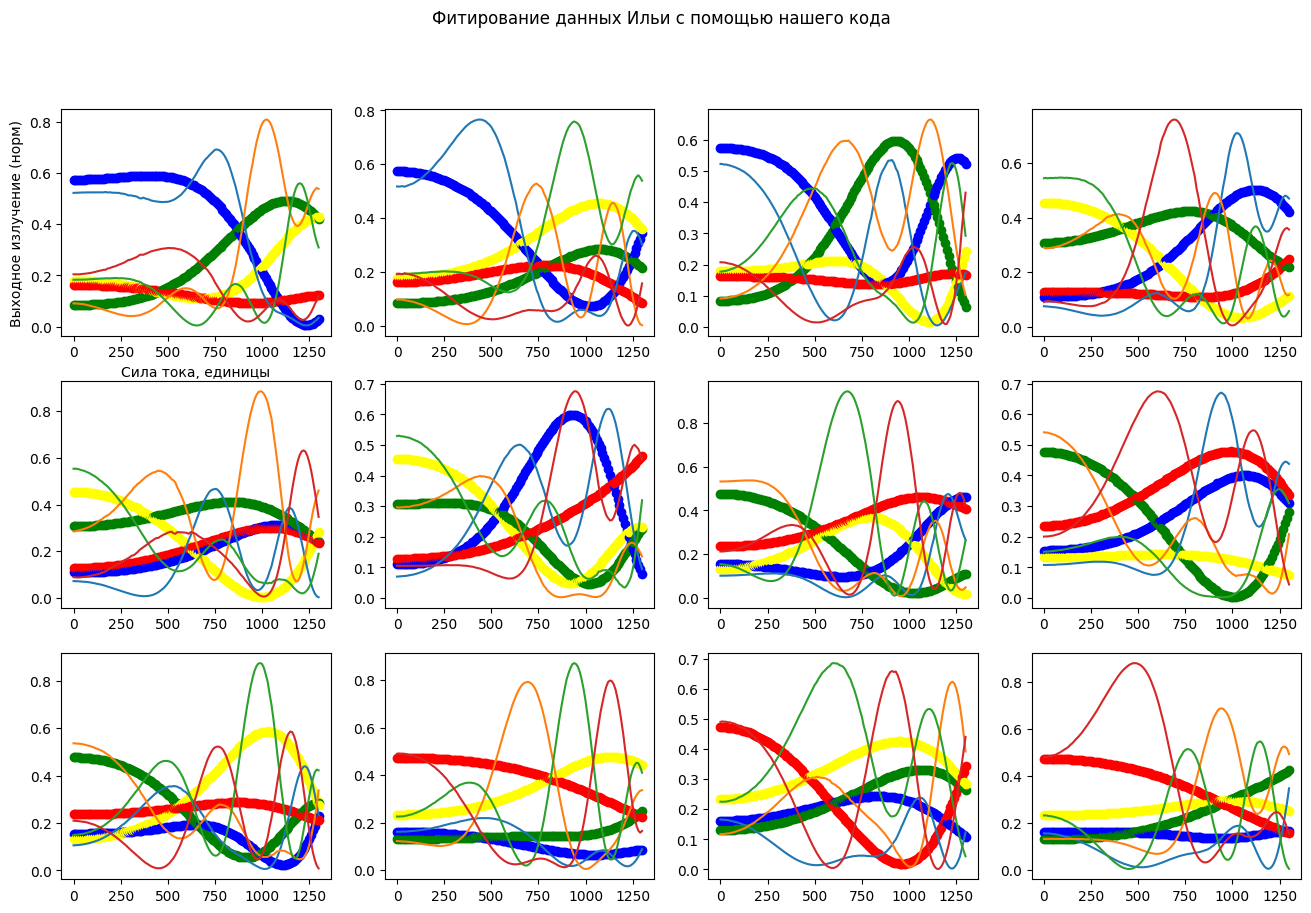

In [75]:
M1 = create_un_mat(x0[:12], device=device)
M2 = create_un_mat(x0[12:24], device=device)
alpha = torch.tensor(x0[24:33], dtype=torch.complex128, device=device).reshape(3, 3)
h_0 = torch.tensor(x0[33:36], dtype=torch.complex128, device=device)

fig, ax = plt.subplots(3, 4, figsize=(16, 10))

for j in range(12):

    for i in data[131*j:131*(j+1)]:
        x = torch.zeros(3, dtype=torch.complex128, device=device)
        x[i[0]] = 10**(-5) * i[2] ** 2
        y = torch.tensor(i[3:], dtype=torch.complex128, device=device)
        y /= torch.sum(y)

        h_list = h_0 + alpha @ x
        H_diag = torch.cat([torch.exp(1j * h_list), torch.tensor([1.0], dtype=torch.complex64, device=device)])
        H = torch.diag(H_diag)
        result = (torch.abs((M2 @ H @ M1).T) ** 2)[i[1]]
        ax[j//4][j%4].scatter(i[2], result[0].cpu().detach().numpy(), color = 'blue')
        ax[j//4][j%4].scatter(i[2], result[1].cpu().detach().numpy(), color = 'green')
        ax[j//4][j%4].scatter(i[2], result[2].cpu().detach().numpy(), color = 'yellow')
        ax[j//4][j%4].scatter(i[2], result[3].cpu().detach().numpy(), color = 'red')

    ax[j//4][j%4].plot([d[2] for d in data[131*j:131*(j+1)]], [d[3]/sum(d[3:]) for d in data[131*j:131*(j+1)]])#, color = 'blue')
    ax[j//4][j%4].plot([d[2] for d in data[131*j:131*(j+1)]], [d[4]/sum(d[3:]) for d in data[131*j:131*(j+1)]])#, color = 'green')
    ax[j//4][j%4].plot([d[2] for d in data[131*j:131*(j+1)]], [d[5]/sum(d[3:]) for d in data[131*j:131*(j+1)]])#, color = 'yellow')
    ax[j//4][j%4].plot([d[2] for d in data[131*j:131*(j+1)]], [d[6]/sum(d[3:]) for d in data[131*j:131*(j+1)]])#, color = 'red')

    ax[0][0].set_xlabel('Сила тока, единицы')
    ax[0][0].set_ylabel('Выходное излучение (норм)')

    fig.suptitle('Фитирование данных Ильи с помощью нашего кода')

   
plt.show()